# Analyzing Employee Sentiments and Rating Patterns Across Leading Tech Companies

## Data set

Here, I upload the dataset containing 5 columns of interest: 'company', 'summary', 'pros', 'cons', and 'overall-ratings'. The goal is to perform a classification task to predict how many 'summary' entries fall into one of the 'overall-ratings' labels ranging from 1 to 5.

In [1]:
# DATASET 
# upload the dataset 
import numpy as np
import pandas as pd

# path of the CSV file
csv_file_path = 'employee_reviews.csv'

# read the CSV file into a DataFrame df
df = pd.read_csv(csv_file_path)
print(df['location'][0:5]) # this is how you have access to the column location and to the first 5 elements 
print('length of the complete dataset', len(df)) # this is how you have access to the number of obs of the dataset 

# clean the dataset 
# columns that I want to work with 
selected_columns = ['company', 'job-title', 'summary', 'pros', 'cons', 'overall-ratings']

# create a new DataFrame with only the selected columns
employee_df = df[selected_columns]
print(employee_df[0:2]) # just to show how the dataset is 


# identify missing values
missing_values = employee_df.isnull().sum()
print('missing_values', missing_values) # I have 127 observations without value 

# remove rows with missing values
employee_df = employee_df.dropna()
print('length of the dataset withoyu missing values', len(employee_df)) # to show that I removed the missing values observations


0                 none
1    Mountain View, CA
2         New York, NY
3    Mountain View, CA
4      Los Angeles, CA
Name: location, dtype: object
length of the complete dataset 67529
  company                              job-title  \
0  google  Current Employee - Anonymous Employee   
1  google      Former Employee - Program Manager   

                                             summary  \
0                           Best Company to work for   
1  Moving at the speed of light, burn out is inev...   

                                                pros  \
0                      People are smart and friendly   
1  1) Food, food, food. 15+ cafes on main campus ...   

                                                cons  overall-ratings  
0                 Bureaucracy is slowing things down              5.0  
1  1) Work/life balance. What balance? All those ...              4.0  
missing_values company              0
job-title            0
summary            127
pros                 0


Cleaning of the dataset through a specific function clean_text()

In [2]:

import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

#define a new function
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text


# applaying the function clean_text on the columns of interest 
employee_df['summary'] = employee_df['summary'].apply(clean_text)
employee_df['pros'] = employee_df['pros'].apply(clean_text)
employee_df['cons'] = employee_df['cons'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\FEM
[nltk_data]     srl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\FEM srl\AppData\Local\Temp\ipykernel_16912\4275186848.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding
C:\Users\FEM srl\AppData\Local\Temp\ipykernel_16912\4275186848.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding
C:\Users\FEM srl\AppData\Local\Temp\ipykernel_16912\4275186848.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text

Splitting the dataset into training and test set for the training and prediction for Naive Bayes Classifier and Support Vector Machine.

In [5]:

# creating TRAINING and TEST sets 
from sklearn.model_selection import train_test_split
# group the DataFrame by the 'company' column
grouped_df = employee_df.groupby('company')

# empty DataFrames for training and test sets
train_set = pd.DataFrame(columns=selected_columns)
test_set = pd.DataFrame(columns=selected_columns)

# split each group into training and test sets with a mix of observations
for _, group_df in grouped_df:
    # test_size=0.2 => 20% in test set and 80% in training set 
    # random_state=42 => it is setting the seed i.e. data splitting will be the same every time you run the code
    group_train_set, group_test_set = train_test_split(group_df, test_size=0.2, random_state=42)

    # append the split sets to the overall training and test sets
    train_set = pd.concat([train_set, group_train_set], ignore_index=True)
    test_set = pd.concat([test_set, group_test_set], ignore_index=True)




After running this last part of code, the data are split in two parts 80% and 20% in each group so that every company remain as important as in the initial dataset.

## METHODS

### NAIVE CLASSIFIER

In [6]:
# 1) NAIVE CLASSIFIER 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Pipeline that combines text vectorization and the Multinomial Naive Bayes classifier:
# the first step ('vect') is to convert the text data into a numerical format using the CountVectorizer,
# and the second step ('clf') is the Multinomial Naive Bayes classifier.
text_clf = Pipeline([
    ('vect', CountVectorizer()),  # Step 1: Text vectorization
    ('clf', MultinomialNB())     # Step 2: Multinomial Naive Bayes classifier
])

#fit the model on the training dataset 
text_clf.fit(train_set['summary'], train_set['overall-ratings'])

# evaluate the model on the test set 
test_pred = text_clf.predict(test_set['summary'])

from collections import Counter
print("Prediction: ", Counter(test_pred))

print("Test set : ", Counter(test_set['overall-ratings']))

print(classification_report(test_set['overall-ratings'], test_pred,)) 



Prediction:  Counter({5.0: 6076, 4.0: 5098, 3.0: 1726, 1.0: 304, 2.0: 279})
Test set :  Counter({5.0: 4644, 4.0: 4522, 3.0: 2466, 2.0: 1055, 1.0: 796})
              precision    recall  f1-score   support

         1.0       0.49      0.19      0.27       796
         2.0       0.32      0.08      0.13      1055
         3.0       0.35      0.24      0.29      2466
         4.0       0.42      0.47      0.44      4522
         5.0       0.51      0.66      0.58      4644

    accuracy                           0.45     13483
   macro avg       0.42      0.33      0.34     13483
weighted avg       0.43      0.45      0.43     13483



Here, I collect all the most important words connected to the levels 1 and 5 

In [7]:
# extract the model Naive Bayes from the pipeline
nb_model = text_clf.named_steps['clf']

# extract log probabilities of the features
log_probabilities = nb_model.feature_log_prob_

# features with highest log probabilities for level 5
features_high_ratings = text_clf.named_steps['vect'].get_feature_names_out()[log_probabilities[4].argsort()[::-1]]
print(features_high_ratings[0:200]) 
print(len(features_high_ratings))

# features with highest log probabilities for level 1
features_low_ratings = text_clf.named_steps['vect'].get_feature_names_out()[log_probabilities[0].argsort()[::-1]]
print(features_low_ratings[0:200]) 




['great' 'work' 'company' 'place' 'best' 'good' 'manager' 'amazing'
 'amazon' 'awesome' 'engineer' 'experience' 'job' 'software' 'specialist'
 'apple' 'people' 'working' 'associate' 'culture' 'microsoft'
 'environment' 'excellent' 'love' 'google' 'ever' 'fun' 'review' 'senior'
 'career' 'one' 'intern' 'program' 'retail' 'benefits' 'nice' 'sales'
 'customer' 'learn' 'analyst' 'advisor' 'support' 'worked' 'technical'
 'hard' 'development' 'opportunities' 'challenging' 'product' 'life'
 'business' 'ive' 'fantastic' 'grow' 'team' 'time' 'service' 'learning'
 'opportunity' 'account' 'fast' 'like' 'employer' 'rewarding' 'growth'
 'engineering' 'operations' 'still' 'world' 'home' 'workplace' 'sr'
 'smart' 'really' 'better' 'make' 'years' 'overall' 'get' 'employees'
 'warehouse' 'internship' 'tech' 'sde' 'wonderful' 'lots' 'marketing'
 'developer' 'exciting' 'employee' 'assistant' 'management' 'lead' 'day'
 'far' 'data' 'big' 'balance' 'start' 'consultant' 'genius' 'impact' 'aws'
 'fulfillment

Here, I show the most significant pairs of words of the level 1 and 5 for each company

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Pipeline that combines text vectorization and the Multinomial Naive Bayes classifier:
# the first step ('vect') is to convert the text data into a numerical format using the CountVectorizer ,
# and the second step ('clf') is the Multinomial Naive Bayes classifier.
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,2))),   #step 1: vectorizer that considers only 2-grams, 
    ('clf', MultinomialNB())  # Step 2: Multinomial Naive Bayes classifier
])

# iterate on each company 
for company in employee_df['company'].unique():
    print(f"Company: {company}")
    
    company_df = employee_df[employee_df['company'] == company]
    
    # splitting the dataset in training and test sets 
    train_data, test_data, train_labels, test_labels = train_test_split(
        company_df['summary'], company_df['overall-ratings'], test_size=0.2, random_state=42)
    
    # fit the model on the training dataset 
    text_clf.fit(train_data, train_labels)
    
    # evaluate the model on the test set 
    predictions = text_clf.predict(test_data)
    
    # computin accuracy for each company
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Accuracy for {company}: {accuracy}")
    
    # extracting the model from the pipeline 
    nb_model = text_clf.named_steps['clf']
    
    # extractig log probabilities of the features
    log_probabilities = nb_model.feature_log_prob_
    
    # for the lowest (1) and the highest (5) overall-ratings, extracting the most important features
    features_for_lowest_rating = text_clf.named_steps['vect'].get_feature_names_out()[log_probabilities[0].argsort()[::-1]]
    features_for_highest_rating = text_clf.named_steps['vect'].get_feature_names_out()[log_probabilities[4].argsort()[::-1]]
    print(f"Most important features for overall-rating {1}: {features_for_lowest_rating[0:100]}")  
    print(f"Number of features for overall-rating {1}: {len(features_for_lowest_rating)}")
    print("\n")
    print(f"Most important features for overall-rating {5}: {features_for_highest_rating[0:100]}")  
    print(f"Number of features for overall-rating {5}: {len(features_for_highest_rating)}")
    print("\n")




Company: google
Accuracy for google: 0.5650224215246636
Most important features for overall-rating 1: ['place work' 'good cv' 'loss competitive' 'google cloud' 'change needed'
 'avoid complacency' 'full time' 'life balance' 'complacency loss'
 'google change' 'needed avoid' 'work life' 'good want' 'lack respect'
 'cloud sales' 'competitive edge' 'blah blah' 'cultlike atmosphere'
 'software engineer' 'work full' 'fulltime employees' 'respect employees'
 'market work' 'respect superficial' 'avoid place' 'avoid unless'
 'google fairy' 'last resort' 'full people' 'full worst' 'ask stylist'
 'came excited' 'great time' 'bad management' 'work anymore' 'free food'
 'manager makes' 'time job' 'software project' 'time avoid' 'company work'
 'thrilling satisfying' 'resume go' 'learn good' 'awesome team'
 'though smart' 'business org' 'leadership lots' 'excited left'
 'resign story' 'retaliatory environment' 'think carefully' 'work last'
 'work google' 'staffing recruiting' 'kashmiri muslim' 'wor

Tuning the model MultinomialNB thorugh the smoothing parameter


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),  # Step 1: Text vectorization
    ('clf', MultinomialNB())     # Step 2: Multinomial Naive Bayes classifier
])

# smoothing parameter to test
param_grid = {'clf__alpha': [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 1.0]}

# GridSearchCV object
grid_search = GridSearchCV(text_clf, param_grid, scoring='f1_weighted', cv=5)

grid_search.fit(train_set['summary'], train_set['overall-ratings'])

# Stampa i risultati
print("Best combination of parameters:", grid_search.best_params_)
print("Best model chosen on the F1-score base", grid_search.best_score_)
print("Accuracy of the model applied on the test set:", accuracy_score(test_set['overall-ratings'], grid_search.predict(test_set['summary'])))

# fit the model on the best parameter
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(train_set['summary'], train_set['overall-ratings'])

# evaluate the model with the best parameter
final_test_pred = best_pipeline.predict(test_set['summary'])
print(classification_report(test_set['overall-ratings'], final_test_pred))


Best combination of parameters: {'clf__alpha': 0.3}
Best model chosen on the F1-score base 0.4100897613274386
Accuracy of the model applied on the test set: 0.44663650522880666
              precision    recall  f1-score   support

         1.0       0.43      0.27      0.33       796
         2.0       0.26      0.11      0.15      1055
         3.0       0.35      0.27      0.30      2466
         4.0       0.42      0.44      0.43      4522
         5.0       0.51      0.66      0.58      4644

    accuracy                           0.45     13483
   macro avg       0.39      0.35      0.36     13483
weighted avg       0.43      0.45      0.43     13483



### SUPPORT VECTOR MACHINE 

In [10]:
# 5) SUPPORT VECTOR MACHINE 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_set['summary'])

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC  # Import Support Vector Classification
from sklearn.metrics import classification_report

# Pipeline that combines text vectorization and the Support Vector Machine classifier:
# the first step ('vect') is to convert the text data into a numerical format using the CountVectorizer,
# and the second step ('clf') is the Support Vector Machine classifier.
text_clf2 = Pipeline([
    ('vect', CountVectorizer()),  # Step 1: Text vectorization
    ('clf', SVC(kernel="linear", C=1.0))                 # Step 2: Support Vector Machine classifier
    #('clf', SVC(kernel="rbf", gamma=0.7, C=1.0))                 # if you use this kernel the accuracy is 0.44
    #('clf', SVC(kernel="poly", degree=3, gamma="auto", C=1.90))  # if you use this kernel the accuracy is 0.34
])

# fit the model on the training dataset
text_clf2.fit(train_set['summary'], train_set['overall-ratings'])

# evaluate the model on the test set
test_pred2 = text_clf2.predict(test_set['summary'])

from collections import Counter
print("Prediction: ", Counter(test_pred2))
print("Test set : ", Counter(test_set['overall-ratings']))

print(classification_report(test_set['overall-ratings'], test_pred2)) 

Prediction:  Counter({5.0: 6232, 4.0: 4969, 3.0: 1486, 1.0: 476, 2.0: 320})
Test set :  Counter({5.0: 4644, 4.0: 4522, 3.0: 2466, 2.0: 1055, 1.0: 796})
              precision    recall  f1-score   support

         1.0       0.49      0.29      0.36       796
         2.0       0.27      0.08      0.13      1055
         3.0       0.37      0.23      0.28      2466
         4.0       0.42      0.46      0.44      4522
         5.0       0.50      0.67      0.57      4644

    accuracy                           0.45     13483
   macro avg       0.41      0.35      0.36     13483
weighted avg       0.43      0.45      0.43     13483



### DOC2VEC AND LOGISTIC REGRESSION

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

from nltk.tokenize import word_tokenize

#adding the column 'tokenized_text' to the DataFrame
employee_df.loc[:, 'tokenized_text'] = employee_df['summary'].apply(lambda text: word_tokenize(str(text).lower()))

# create labeled documetns with 1,2,3... as unique tags
labeled_data = [TaggedDocument(words=doc, tags=[str(tag)]) for doc, tag in zip(employee_df['tokenized_text'], range(len(employee_df['summary'])))]

# fit the model Doc2Vec with the following parameters 
vector_size = 500   #dimensionality of the feature vectors 
window = 5          # maximum distance between the current and predicted word within a sentence
min_count = 1       # ignores all words with a total frequency lower than this
workers = 4         # number of CPU cores to use when training the model
epochs = 10         # number of iterations (epochs) over the corpus during training


model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
model.build_vocab(labeled_data)
model.train(labeled_data, total_examples=model.corpus_count, epochs=model.epochs)

# list of all vector connected to each summary 
doc_vectors = [model.dv[idx] for idx in range(len(labeled_data))] 


# applying logisticregression classifier 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, employee_df['overall-ratings'], test_size=0.2, random_state=42)
company_train, company_test, y_train2, y_test2=  train_test_split(employee_df['company'], employee_df['overall-ratings'], test_size=0.2, random_state=42)
# Initialize and train a logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# evaluate the model on the test set 
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

[nltk_data] Downloading package punkt to C:\Users\FEM
[nltk_data]     srl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Accuracy: 0.38706327423781617


### COMPARING RESULTS BETWEEN COMPANIES OF THE BEST CLASSIFIER

### NAIVE CLASSIFIER 
 

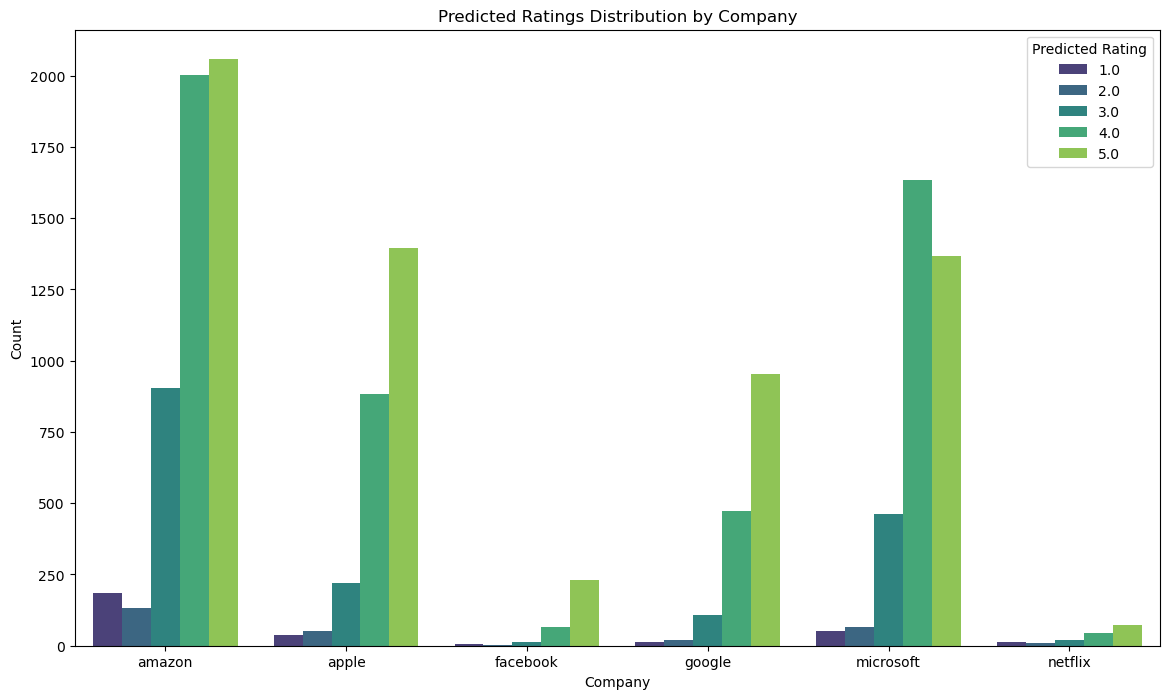

Predicted_Rating       1.0       2.0        3.0        4.0        5.0
Company                                                              
amazon            3.486169  2.482001  17.127700  37.912088  38.992042
apple             1.431335  1.934236   8.510638  34.197292  53.926499
facebook          1.577287  0.630915   4.100946  21.135647  72.555205
google            0.768738  1.217168   6.854580  30.172966  60.986547
microsoft         1.480034  1.843061  12.901424  45.573862  38.201620
netflix           8.074534  6.832298  12.422360  26.708075  45.962733
Predicted_Rating  Low Ratings  High Ratings
Company                                    
amazon               5.968170     76.904130
apple                3.365571     88.123791
facebook             2.208202     93.690852
google               1.985906     91.159513
microsoft            3.323094     83.775482
netflix             14.906832     72.670807


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

company_column = 'company'

# datafram with predictions and company names
predictions_df = pd.DataFrame({'Predicted_Rating': test_pred, 'Company': test_set[company_column]})

# barplot of predictions on overall-ratings in each company 
plt.figure(figsize=(14, 8))
sns.countplot(x='Company', hue='Predicted_Rating', data=predictions_df, palette='viridis', dodge=True)
plt.title('Predicted Ratings Distribution by Company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.legend(title='Predicted Rating', loc='upper right')
plt.show()


# percentages of different levels 1,2,3,4,5
company_level_counts = predictions_df.groupby(['Company', 'Predicted_Rating']).size().unstack(fill_value=0)
company_level_percentages = company_level_counts.div(company_level_counts.sum(axis=1), axis=0) * 100
print(company_level_percentages)


# sum the percentages of 1 and 2, and 4 and 5
company_level_percentages['Low Ratings'] = company_level_percentages[[1, 2]].sum(axis=1)
company_level_percentages['High Ratings'] = company_level_percentages[[4, 5]].sum(axis=1)

print(company_level_percentages[['Low Ratings', 'High Ratings']])


## WORDCLOUD 

Here, the code focuses on 'pros' and 'cons' columns and extract the most significant pairs of words for the highest values and the lowest values.

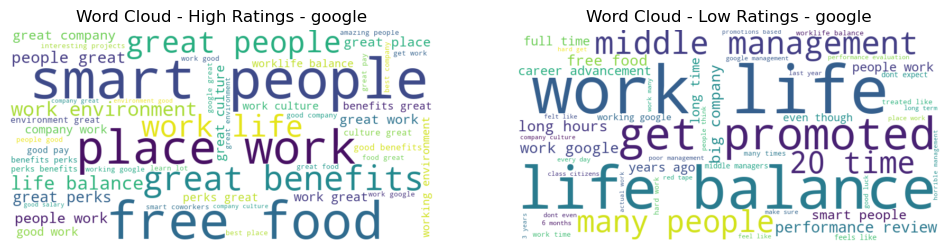

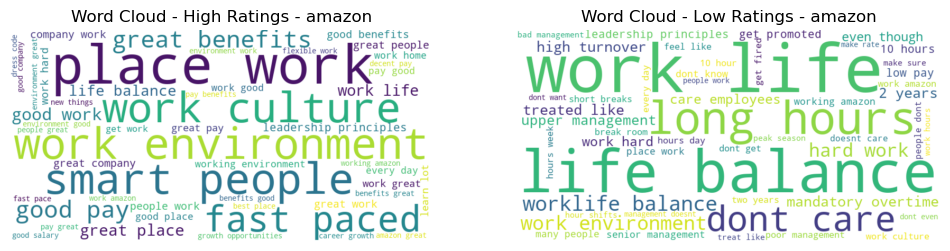

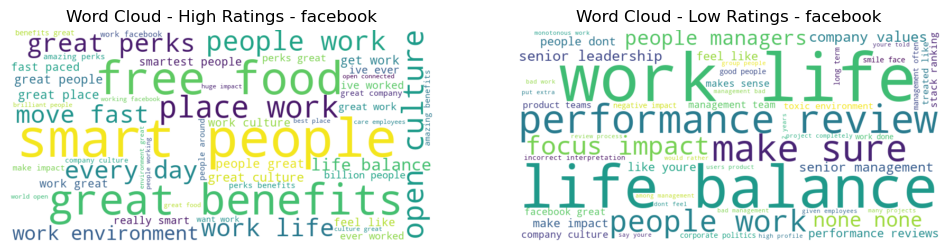

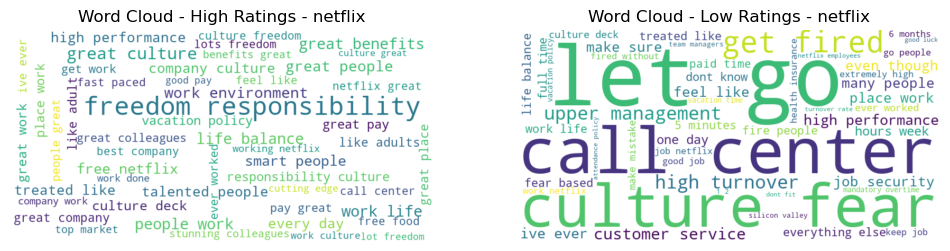

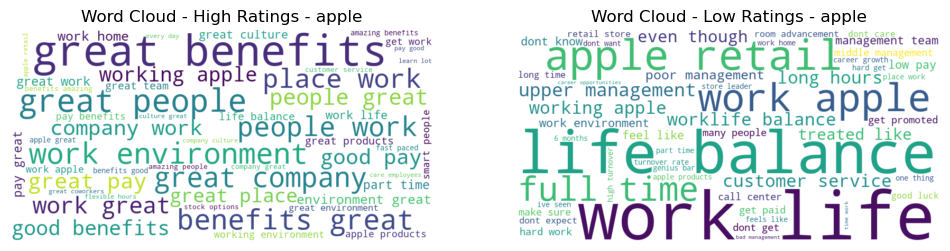

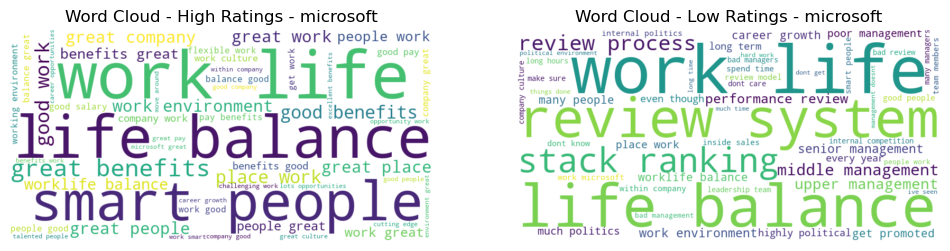

In [32]:
from wordcloud import WordCloud
from nltk import ngrams
from nltk import FreqDist
import matplotlib.pyplot as plt

employee_df = employee_df[employee_df['pros'].str.lower() != 'none']
employee_df = employee_df[employee_df['cons'].str.lower() != 'none']


# function for the generation of bigrams
def generate_bigrams(text):
    words = text.split()
    bigram_tokens = list(ngrams(words, 2))
    return [' '.join(bigram) for bigram in bigram_tokens]

companies = employee_df['company'].unique()

# considering only the highest and lowest ratings 
high_ratings = [4, 5]
low_ratings = [1, 2]


# creating a dictionary for each company 
for company in companies:
    all_bigrams = {}
    
    #'high ratings for the column pros 
    text_high = ' '.join(employee_df[(employee_df['company'] == company) & (employee_df['overall-ratings'].isin(high_ratings))]['pros'])

    # generating the bigrams 
    bigrams = generate_bigrams(text_high)

    # updating the number of bigrams for the dictionary 
    for bigram in bigrams:
        if bigram in all_bigrams:
            all_bigrams[bigram] += 1
        else:
            all_bigrams[bigram] = 1

    # find the 50 most frequent bigrams
    top_bigrams = FreqDist(all_bigrams).most_common(50)

    # word cloud with the most frequent bigrams
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_bigrams))
     
    # do the same for the lowest ratings in the columns 'cons'
    all_bigrams = {}
    
    text_low = ' '.join(employee_df[(employee_df['company'] == company) & (employee_df['overall-ratings'].isin(low_ratings))]['cons'])

    
    bigrams_low = generate_bigrams(text_low)

    for bigram in bigrams_low:
        if bigram in all_bigrams:
            all_bigrams[bigram] += 1
        else:
            all_bigrams[bigram] = 1

    top_bigrams_low = FreqDist(all_bigrams).most_common(50)

    wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_bigrams_low))


   
    # visualitation of the word clouds 
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - High Ratings - {company}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_low, interpolation='bilinear')
    plt.title(f'Word Cloud - Low Ratings - {company}')
    plt.axis('off')

    plt.show()

    
